In [12]:
## This jupyter notebook need to be run in main folder
import numpy as np
import pandas as pd
from src.concat_image import *
from src.metrics_acc_iou import *
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [2]:
mit = pd.read_csv("logs/mit_vs_psp_acc_iou_annotation.csv")

In [4]:
# label_info = np.zeros((len(mit), 153))  ## Columns: Width, Height, labels 0 ~ 150 
# labels = ["lab_" + str(i) for i in range(0, 151)]
# label_columns = ["width", "height"]
# label_columns.extend(labels)
# for i in range(len(mit)):
#     annot_path = mit["val_img"][i]
#     annot_path = "data/ADEChallengeData2016/annotations/" + annot_path[:-4] + ".png"
#     annot_img = imread(annot_path)
#     w, h = annot_img.shape
#     label_info[i, 0] = w
#     label_info[i, 1] = h
#     img_label_list = np.unique(annot_img)
#     for img_label in img_label_list:
#         label_info[i, img_label + 2] = np.sum(annot_img == img_label)/float(w * h)
# label_df = pd.DataFrame(label_info, columns=label_columns)
# mit = pd.concat([mit, label_df], axis=1)

In [63]:
mit.head(2)

,Unnamed: 0,val_img,acc,iou,psp50_acc,psp50_iou,scene,width,height,lab_0,...,lab_141,lab_142,lab_143,lab_144,lab_145,lab_146,lab_147,lab_148,lab_149,lab_150
0,0,validation/ADE_val_00000001.jpg,0.632343,0.620235,0.952150,0.770030,abbey,512.0,683.0,0.010332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,validation/ADE_val_00000002.jpg,0.917770,0.521776,0.878315,0.393003,abbey,364.0,500.0,0.094945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
acc = mit.groupby(["scene"]).mean()["acc"]
count = mit.groupby(["scene"]).count()["acc"]
var = mit.groupby(["scene"]).var()["acc"]
scene_df = pd.concat([acc,count,var], axis = 1)
scene_df.columns = ["mean acc", "count", "var acc"]
scene_df = scene_df.sort_values("mean acc")
scene_df.to_csv("scene_acc.csv")

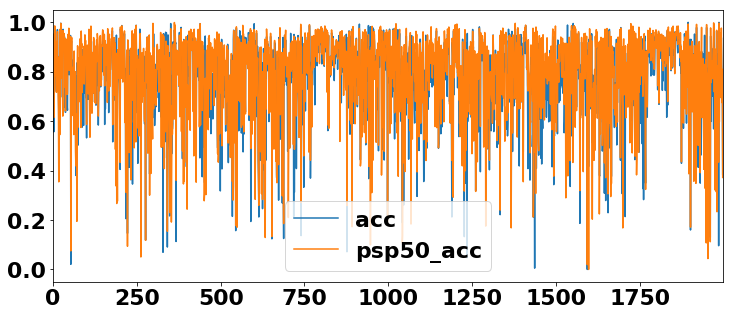

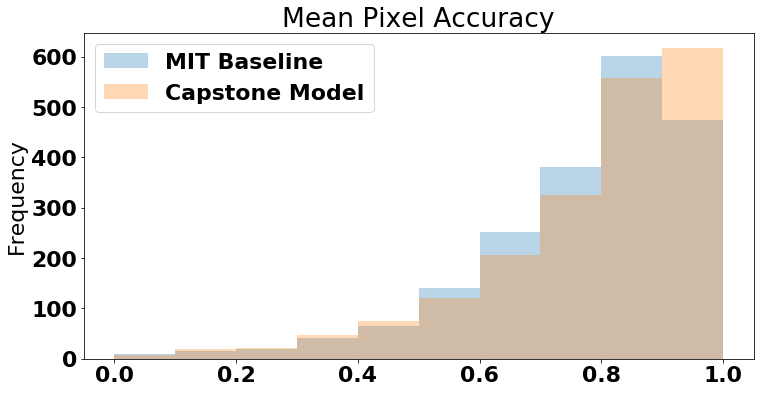

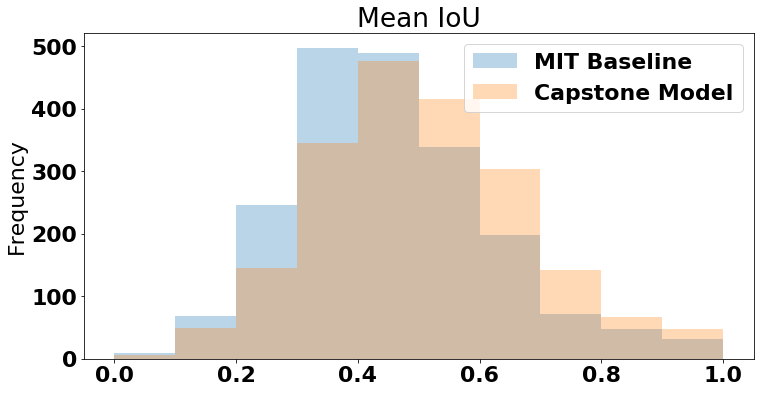

In [18]:
mit.plot(x = mit.index, y = ["acc", "psp50_acc"], figsize=(12,5))
ax = mit[["acc", "psp50_acc"]].plot(kind="hist", alpha = 0.3, figsize = (12,6), title="Mean Pixel Accuracy")
ax.legend(["MIT Baseline", "Capstone Model"])
fig = ax.get_figure()
fig.savefig("Mean_Pixel_Accu.jpg")
ax = mit[["iou", "psp50_iou"]].plot(kind="hist", alpha = 0.3, figsize = (12,6), title="Mean IoU")
ax.legend(["MIT Baseline", "Capstone Model"])
fig = ax.get_figure()
fig.savefig("Mean_IoU.jpg")

In [53]:
colors = loadmat("data/color150.mat")['colors'] ## Load colormap
image_folder = "data/ADEChallengeData2016/images/validation/"
annot_folder = "data/ADEChallengeData2016/annotations/validation/"
pred_list_psp = [x.rstrip() for x in open("results/pspnet50/val_list", 'r')]
pred_list_mit = [x.rstrip() for x in 
                open("results/baseline-resnet34_dilated8-psp_bilinear/val_list.txt", 
                         'r')]
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
obj_df = pd.read_csv("data/object150_info.csv")
def colorlabel(color_list, index):
    obj_list = obj_df[obj_df["Idx"].isin(color_list+1)]["Name"].values
    n_obj = len(obj_list)
    img_list = ["color150/" + obj.split(";")[0] + ".jpg" for obj in obj_list]
    images = map(Image.open, img_list)
    widths, heights = zip(*(i.size for i in images))
    total_height = sum(heights)
    width_max = max(widths)
    new_im = Image.new('RGB', (width_max , total_height))
    y_offset = 0
    for im in images:
      new_im.paste(im, (0, y_offset))
      y_offset += im.size[1]
    new_im.save("color" + str(index) + ".jpg")
    new_im.show()
    plt.imshow(np.asarray(new_im))
    plt.axis('off')
def check_img(index, model):
    if model == "pspnet50":
        pred_path = pred_list_psp[index]
    else:
        pred_path = pred_list_mit[index]
    pred_pic = np.load(pred_path) - 1
    picname = pred_path.split("/")[-1][:-4]
    raw_path = image_folder + picname + ".jpg"
    val_path = annot_folder + picname + ".png"
    raw_pic = imread(raw_path)
    val_pic = imread(val_path).astype("int16") - 1
    img_comb_ = ConcatenateImg(raw_pic, val_pic, pred_pic, colors)
    plt.imshow(img_comb_)
    plt.axis('off')
    pred_color = np.unique(pred_pic)
    val_color = np.unique(val_pic)
    color_list = np.unique(np.union1d(pred_color, val_color))
    color_list = color_list[color_list > 0]
    return color_list

def visualize_singleimg(index):
    fig = plt.figure(figsize=(15,7))
    color_list_psp = check_img(index, "pspnet50")
    plt.title("Capstone")
    fig.savefig("psp50" + str(index) + ".jpg")
    plt.show()
    fig = plt.figure(figsize=(15,7))
    color_list_mit = check_img(index, "mit")
    plt.title("MIT Baseline")
    plt.savefig("MIT" + str(index) + ".jpg")
    plt.show()
    color_list = np.unique(np.union1d(color_list_psp, color_list_mit))
    colorlabel(color_list, index)

In [64]:
sort_df = mit.sort_values("acc")
sort_df[sort_df['Unnamed: 0'] == 0]

,Unnamed: 0,val_img,acc,iou,psp50_acc,psp50_iou,scene,width,height,lab_0,...,lab_141,lab_142,lab_143,lab_144,lab_145,lab_146,lab_147,lab_148,lab_149,lab_150
0,0,validation/ADE_val_00000001.jpg,0.632343,0.620235,0.95215,0.77003,abbey,512.0,683.0,0.010332,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


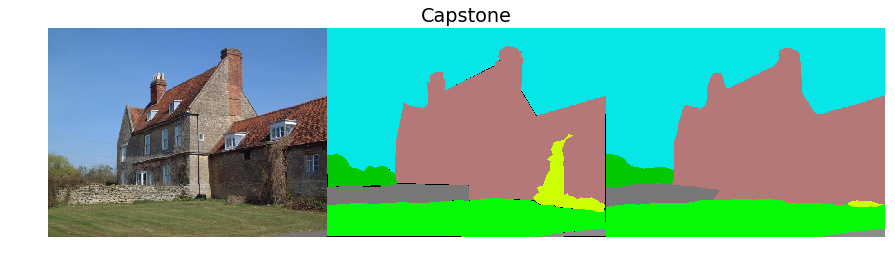

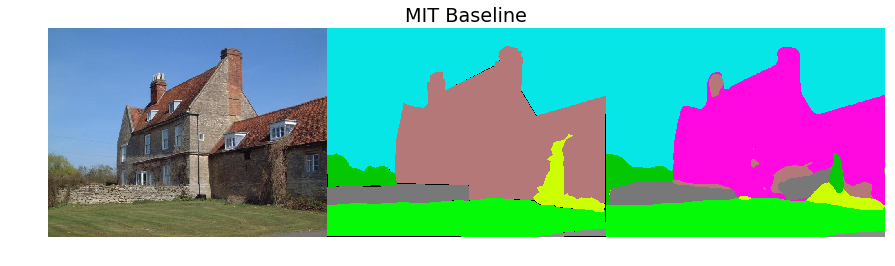

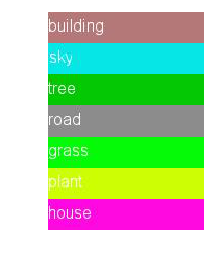

In [55]:
visualize_singleimg(0)  ## Confusion house and building

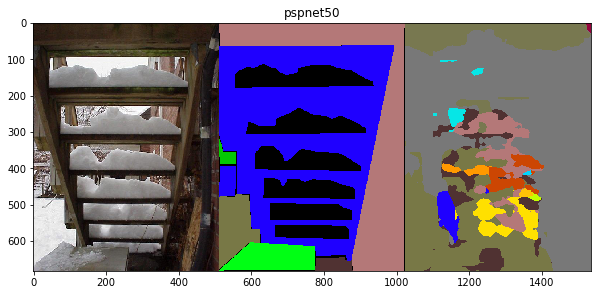

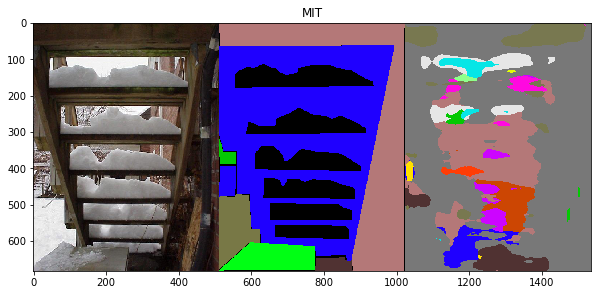

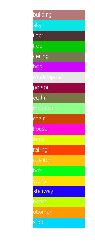

In [183]:
visualize_singleimg(53) ## Challengenging staircase 

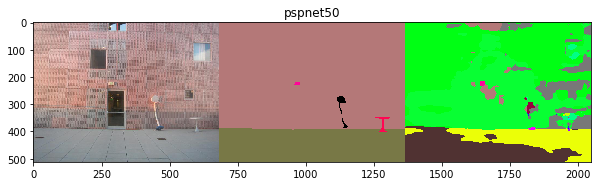

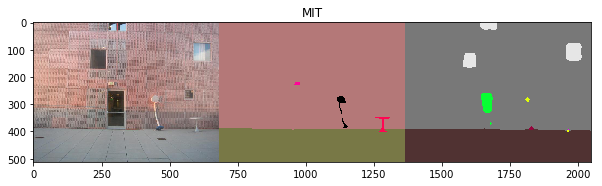

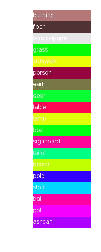

In [186]:
visualize_singleimg(1594) ## Confusion annotation, and insufficient MIT has good door and window, but not annotated. Low accuracy

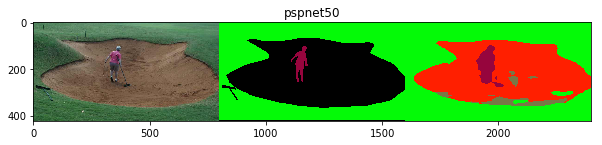

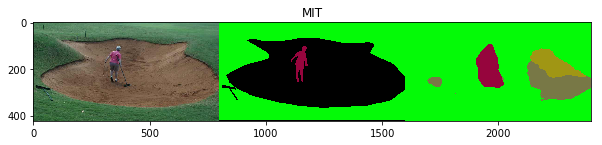

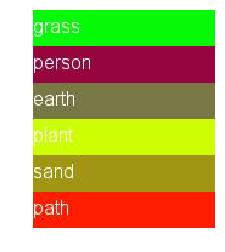

In [189]:
visualize_singleimg(1987) ## Simple case, high accuracy

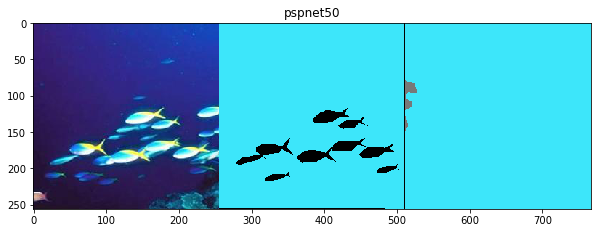

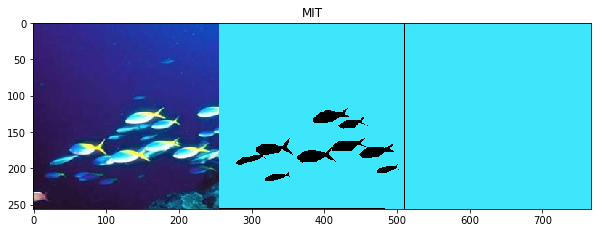

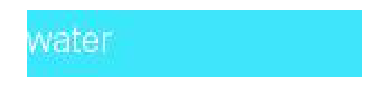

In [190]:
visualize_singleimg(1895) ## Simple water high accuracy

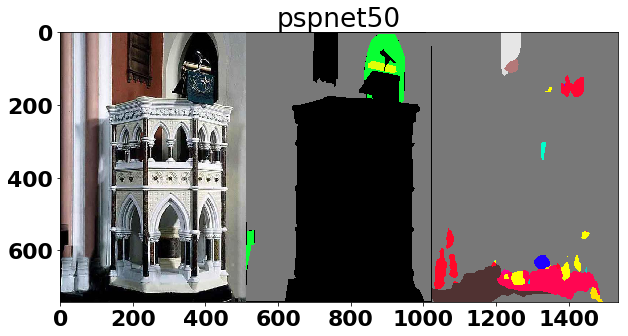

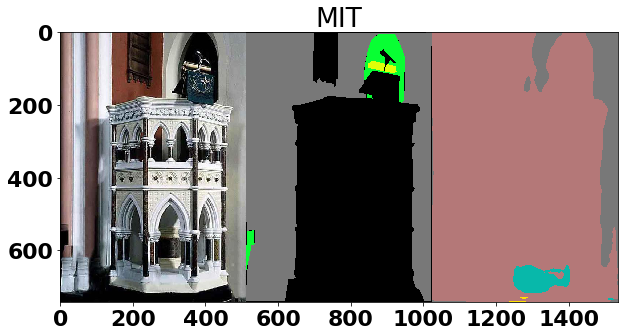

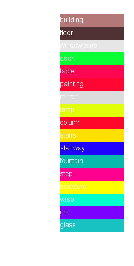

In [215]:
visualize_singleimg(718)  ## In sufficient annotation